In [1]:
import numpy as np
import numpy.linalg as LA
import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange

In [2]:
n = 50
m = 100
num_itr = 50
K = 100
Rambda = 3.0
adam_lr1 = 1e-4
adam_lr2 = 1e-2
max_inner = 50
A = np.random.randn(m, n)
Pinv = LA.inv(A.T @ A + Rambda * np.eye(A.shape[-1]) ) @ A.T
eig, _ = LA.eig(A.T @ A + Rambda * np.eye(A.shape[-1]))
lambda_min = min(eig)
lambda_max = max(eig)
eta_opt = 2/(lambda_min + lambda_max)

In [3]:
def gen_x_opt(y):
    return Pinv @ y
batch_gen_x_opt = jax.vmap(gen_x_opt, in_axes=-1,out_axes=-1)

In [4]:
def GD(max_itr, y):
    x = np.zeros((n, K))
    for i in range(max_itr):
        x -= eta_opt * ( A.T @ ( A@x - y) + Rambda * x)
    return x

def comp_mse(max_itr):
    y = np.random.randn(m, K)
    x_opt = batch_gen_x_opt(y)
    x_hat = GD(max_itr, y)
    return np.sum(batch_get_dot(x_opt - x_hat))/K

In [7]:
def get_dot(x):
    return x @ x.T
batch_get_dot = jax.vmap(get_dot, in_axes=-1, out_axes=-1)

In [8]:
df = pd.DataFrame()
df["iteration"] = list(range(num_itr))
df["GD (fixed step size)"] = [float(comp_mse(i)) for i in range(num_itr)]

In [9]:
def DU_GD(max_itr, y, eta, xi, enable_xi):
    x = jnp.zeros((n, K))
    for i in range(max_itr):
        k = (i % T)
        if (enable_xi == True):
            x -= eta[k] * (A.T @ (A @ x -y) + jnp.abs(xi[i])*x)
        else:
            x -= eta[k] * (A.T @ (A @ x -y) + Rambda * x)
    return x

In [10]:
def loss(x_opt, max_itr, y, enable_xi, eta, xi):
    x_hat = DU_GD(max_itr, y, eta, xi, enable_xi)
    return jnp.sum(batch_get_dot(x_opt - x_hat))/K

In [11]:
opt_init1, opt_update1, get_params1 = optimizers.adam(adam_lr1)
opt_init2, opt_update2, get_params2 = optimizers.adam(adam_lr2)

# @jax.jit
def step(x_opt, max_itr, y, step, opt_state, opt_update, eta, xi, grad_arg_num):
    value, grads = jax.value_and_grad(loss, argnums=grad_arg_num)(x_opt, max_itr, y, enable_xi, eta, xi)
    new_opt_state = opt_update(step, grads, opt_state)
    return value, new_opt_state

def train(eta, xi, enable_xi):
    opt_state1 = opt_init1(eta)
    opt_state2 = opt_init2(xi)
    
    for itr in trange(num_itr, leave=False):
        for i in range(max_inner):
            y = np.random.randn(m, K)
            x_opt = jnp.array(batch_gen_x_opt(y))
            value, opt_state1 = step(x_opt, itr+1, y, i, opt_state1, opt_update1, get_params1(opt_state1), get_params2(opt_state2), -2)
            if(enable_xi):
                _, opt_state2 = step(x_opt, itr+1, y, i, opt_state2, opt_update2, get_params1(opt_state1), get_params2(opt_state2), -1)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params1(opt_state1), get_params2(opt_state2)

In [12]:
def comp_mse_DUGD(max_itr, eta, xi, enable_xi):
    y = np.random.randn(m, K)
    x_opt = jnp.array(batch_gen_x_opt(y))
    return loss(x_opt, max_itr, y, enable_xi, eta, xi)

In [13]:
T = 4
enable_xi = False
eta_init = jnp.zeros(num_itr)
xi_init = Rambda * jnp.ones(num_itr)
eta_trained, xi_trained = train(eta_init, xi_init, enable_xi)

  0%|          | 0/50 [00:00<?, ?it/s]

loss:4.7153568516478117e-07 

In [14]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, xi_trained, enable_xi) for i in range(num_itr)]
df["DU-GD $\lambda$ fixed"] = np.array(DUGD_mse)

In [27]:
enable_xi = True
eta_trained, xi_trained = train(eta_init, xi_init, enable_xi)

  0%|          | 0/50 [00:00<?, ?it/s]

loss:6.443460875971141e-09  

In [30]:
DUGD_mse = [comp_mse_DUGD(i+1, eta_trained, xi_trained, enable_xi) for i in range(num_itr)]
df["DU-GD $\lambda$ trained"] = np.array(DUGD_mse)
df["xi"] = np.array(xi_trained)

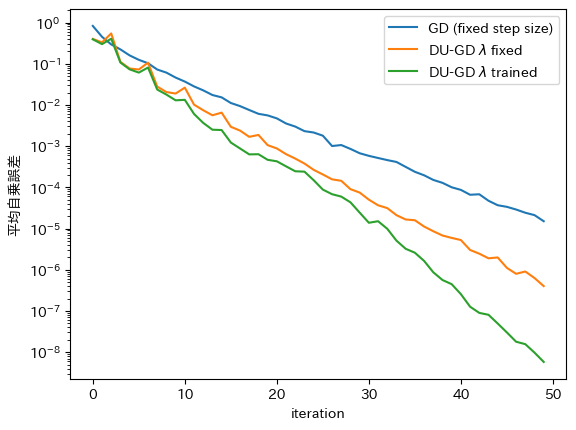

In [32]:
df.plot("iteration", ["GD (fixed step size)", "DU-GD $\lambda$ fixed", "DU-GD $\lambda$ trained"])
plt.yscale("log")
plt.ylabel("平均自乗誤差");

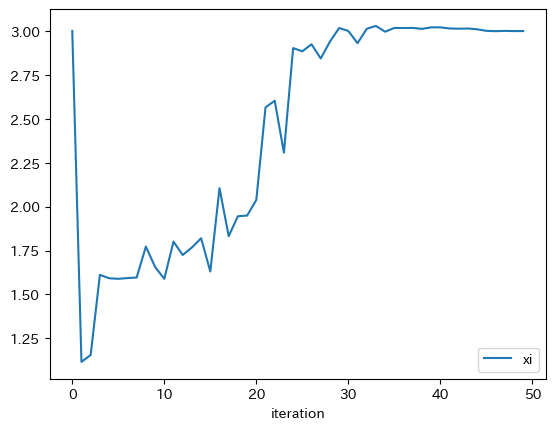

In [33]:
df.plot("iteration", "xi");